# Find and inspect nodes that could be origins of Pango lineages

In [1]:
import os
import tszip
import sc2ts

ts_dir = "../data"
filename = os.path.join(ts_dir, "maskdel-v1-mm_4-f_500-mrm_2-mms_5-mrec_2-rw_7-mgs_10-2023-02-21-il.dated.tsz")
ts = tszip.load(filename)
print(
    f"Loaded {ts.nbytes/1e6:0.1f} megabyte SARS-CoV2 genealogy of {ts.num_samples} strains",
    f"({ts.num_trees} trees, {ts.num_mutations} mutations over {ts.sequence_length} basepairs).",
    f"Last collection date is {ts.node(ts.samples()[-1]).metadata['date']}",
)
ti = sc2ts.TreeInfo(ts)


Loaded 891.6 megabyte SARS-CoV2 genealogy of 850515 strains (171 trees, 1344816 mutations over 29904.0 basepairs). Last collection date is 2023-02-21


Classifying mutations: 100%|██████████| 1344816/1344816 [00:08<00:00, 155553.95it/s]


In [2]:
# Check whether the earliest imputed pango lineage has at least CUTOFF % of the
# those pango samples as descendants
import collections
from tqdm.auto import tqdm
import numpy as np

pango_lineage_nodes = {
    pango: v.copy() for pango, v in ti.pango_lineage_samples.items()
    if not pango.startswith("Unknown") and len(v) > 0
}
# Add imputed nodes to the list of nodes IDs for each pango lineage
for n in tqdm(ts.nodes()):
    if "Viridian_pangolin" not in n.metadata:  # imputed V_pango
        pango = n.metadata["Imputed_Viridian_pangolin"] #imputed_type[n.id]
        if not pango.startswith("Unknown") and pango in pango_lineage_nodes:
            pango_lineage_nodes[pango].append(n.id)

max_desc = np.zeros(ts.num_nodes, dtype=int)
max_pango = {pango: 0 for pango in pango_lineage_nodes.keys()}
best_pango = {}

# Find the max descendants in any tree of the pango lineage associated with each node
for pango, nodes in tqdm(pango_lineage_nodes.items()):
    pango_samples =  ti.pango_lineage_samples[pango]
    for tree in ts.trees(tracked_samples=pango_samples):
        for u in nodes:
            max_desc[u] = max(max_desc[u], tree.num_tracked_samples(u))
    for u in nodes:
        max_pango[pango] = max(max_pango[pango], max_desc[u])
    best_pango[pango] = max_pango[pango] / len(ti.pango_lineage_samples[pango])

  0%|          | 0/994380 [00:00<?, ?it/s]

  0%|          | 0/1873 [00:00<?, ?it/s]

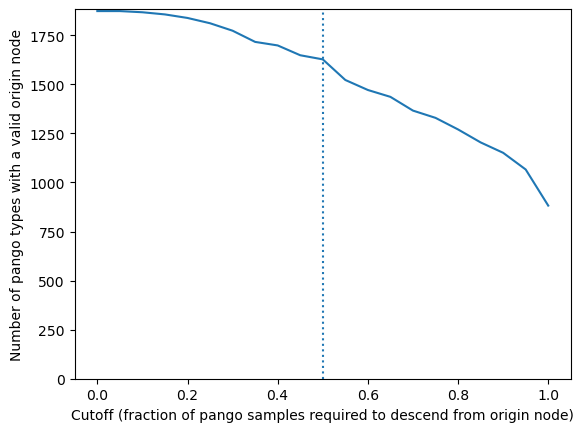

In [3]:
from matplotlib import pyplot as plt
x = np.linspace(0, 1, 21)
plt.plot(x, [np.sum(np.array(list(best_pango.values())) >= cutoff) for cutoff in x])
plt.ylim(0, len(best_pango)+10)
plt.xlabel("Cutoff (fraction of pango samples required to descend from origin node)")
plt.ylabel("Number of pango types with a valid origin node")
plt.axvline(0.5, ls=":")

Check on which Pango lineages require surprisingly low cutoffs:

In [4]:
print({pango: float(cutoff) for pango, cutoff in best_pango.items() if cutoff < 0.2})

{'B.1.147': 0.17985611510791366, 'B.1.128': 0.14285714285714285, 'B.1.319': 0.15384615384615385, 'B.1.1.83': 0.16666666666666666, 'B.1.1.220': 0.17543859649122806, 'B.1.1.135': 0.16666666666666666, 'B.1.252': 0.17647058823529413, 'B.1.143': 0.07142857142857142, 'B.1.1.200': 0.10526315789473684, 'B.1.1.304': 0.18181818181818182, 'B.1.280': 0.1875, 'B.1.177.7': 0.07241379310344828, 'B.1.177.82': 0.13829787234042554, 'C.17': 0.15384615384615385, 'AY.4.5': 0.1524163568773234, 'AY.5.4': 0.17857142857142858, 'BA.1.1.16': 0.15789473684210525, 'BA.2.36': 0.11557788944723618, 'BA.2.65': 0.08808290155440414, 'BA.2.66': 0.14285714285714285, 'BE.1.1': 0.07710144927536232, 'BA.5.2.22': 0.11764705882352941, 'BA.5.2.4': 0.12121212121212122, 'BV.2': 0.1875, 'BA.4.6.4': 0.18181818181818182, 'BA.5.2.38': 0.16666666666666666, 'BA.2.75': 0.14285714285714285, 'BN.6': 0.16666666666666666, 'BQ.1.22': 0.09523809523809523, 'XBB.1.1': 0.15151515151515152, 'BQ.1.27': 0.14285714285714285, 'BQ.1.31': 0.18181818181

In [5]:
from sc2ts.lineages import read_in_mutations
lineage_defining_muts = read_in_mutations("../data/consensus_mutations.json")

Inspect one of the surprising Pango lineages

Highlighting 139 samples in cyan and 11 in orange
8 lineage-defining mutations have been underlined, out of {14408: 'T', 23403: 'G', 241: 'T', 3037: 'T', 15324: 'T', 25433: 'T'}


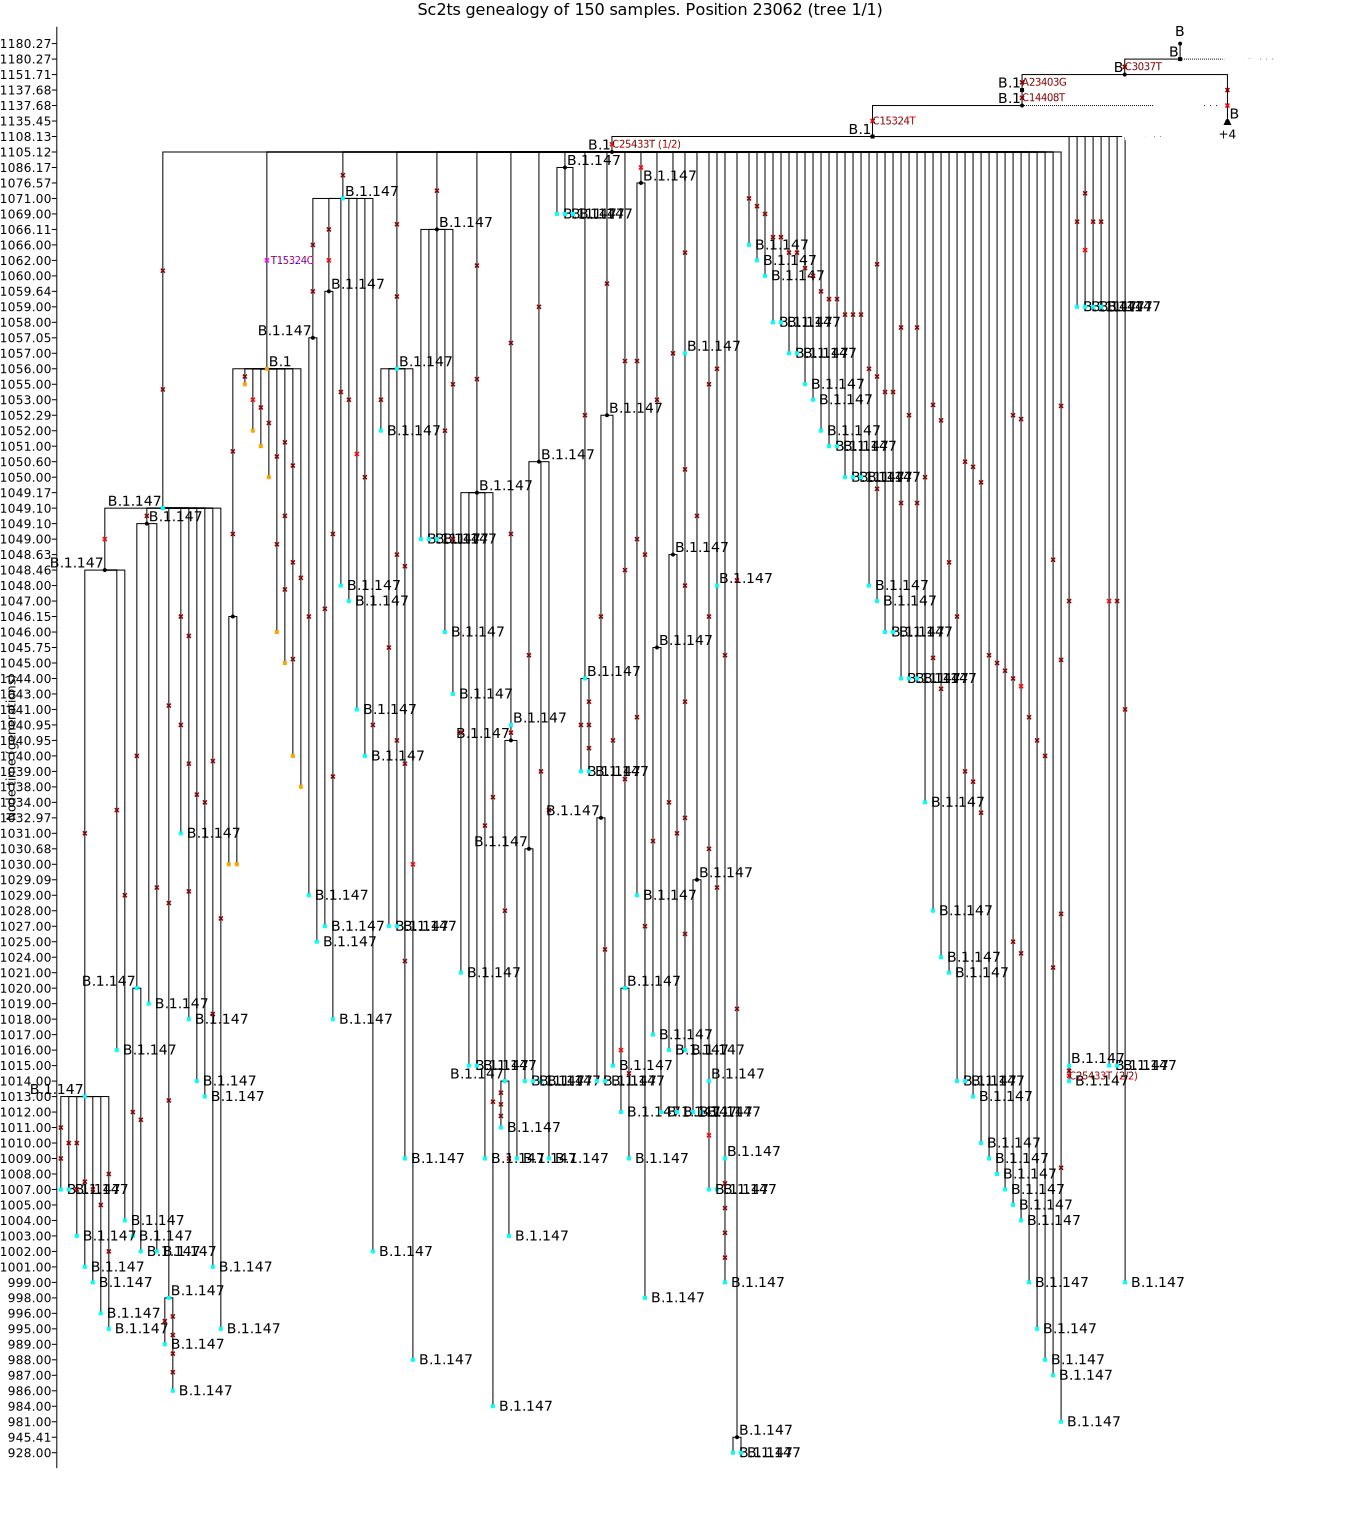

In [6]:
import tskit

pos = 23062
tree = ts.at(pos)
PANGO = "B.1.147"

focal = np.concatenate([v for k, v in ti.pango_lineage_samples.items() if k == PANGO])
# Change the EXTRA_NODE_TARGET below to add additional orange samples
EXTRA_NODE_TARGET = 1053  # Choose a node within the target clade that has extra non-PANGO samples
extra_samples = {n for n in set(tree.nodes(EXTRA_NODE_TARGET)) & set(ts.samples()) if n not in focal}


if extra_samples & set(tree.samples(tree.mrca(*focal))) != extra_samples:
    print("Chosen extra samples are not all in the tree (check which EXTRA_NODE_TARGET you are using).")
    extra_samples = None
print(f"Highlighting {len(focal)} samples in cyan and {len(extra_samples)} in orange")


shown_nodes = set(
    tskit.drawing._postorder_tracked_minlex_traversal(
        ts.at(pos, tracked_samples=focal), #collapse_tracked=collapse_tracked
    )
)

linmut_data = dict(zip(*lineage_defining_muts.get_mutations(PANGO)))
mut_labels, linmuts = {}, []
for s in ts.sites():
    for m in s.mutations:
        anc = ts.mutation(m.parent).derived_state if m.parent >= 0 else s.ancestral_state
        if m.node in shown_nodes and int(s.position) in linmut_data:
            mut_labels[m.id] = f"{anc}{int(s.position)}{m.derived_state}"
            if m.derived_state == linmut_data[int(s.position)]:
                linmuts.append(m.id)
assert len(linmuts) > 0 and len(mut_labels) > 0 
print(f"{len(linmuts)} lineage-defining mutations have been underlined, out of {linmut_data}")

rng = np.random.default_rng(123)
svg = ti.draw_subtree(
    position=pos,
    tracked_samples=focal,  # sorted(focal, key=lambda u: ts.nodes_time[u])[-20:]
    #tracked_pango=["B.1.1.7"],
    time_scale="rank",
    size=(1300, 1500),
    canvas_size=(1370, 1520),
    #collapse_tracked=1, 
    extra_tracked_samples=extra_samples,
    style=(
        ".plotbox {transform: translateX(40px)}"
        ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
        ".mut .lab.lft {text-anchor: start; transform: translateX(3px)}"
        + (",".join([f".node.n{u} > .sym" for u in focal]) + "{fill: cyan}") # in case not all focal
        + (",".join([f".mut.m{m} > .lab" for m in linmuts]) + "{text-decoration: underline}")
    ),
    mutation_labels=mut_labels,
    node_labels={u: ts.node(u).metadata["Imputed_Viridian_pangolin"] for u in shown_nodes}
)
svg